### Import Libraries

In [49]:
from Feature_Engineering import feature_engineering
from businessscoring import businessgain
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import sklearn.model_selection as ms
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score, classification_report, make_scorer
from imblearn.over_sampling import RandomOverSampler
from imblearn import over_sampling

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Pre-Processing

In [50]:
#feature engineering on full dataset
features = feature_engineering(j_flag=0)

In [51]:
#convert potential fraud values to 0 and 1
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})

In [52]:
#create variables for features and target
X = features.drop(['PotentialFraud', 'Service_Type','Provider', 'Both_Service',\
                   'Inpatient', 'Gender2', 'Race5' ], axis=1)
y = features['PotentialFraud'] 

In [53]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Outpatient','isFraudConnected']]

#drop dummy variables
X = X.drop(['Outpatient','isFraudConnected'], axis =1)

In [54]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)

#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)

In [55]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [56]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
#SMOTE upsampling
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

In [58]:
#random over sampling 
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [59]:
#business_score = make_scorer(businessgain, greater_is_better=True)

In [60]:
#create dataframe for model plot
business_scores = pd.DataFrame(columns=('Model', 'Score'))

### Logistic Regression

#### SMOTE

In [61]:
# SMOTE balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("SMOTE; \nLogistic Regression Baseline F1 score: ", f1_score(y_test,logistic.predict(X_test)))

SMOTE; 
Logistic Regression Baseline F1 score:  0.8506787330316742


In [62]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}

grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 781 ms, sys: 112 ms, total: 893 ms
Wall time: 4.55 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='f1')

In [63]:
#SMOTE
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train F1 score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set F1 score: ", f1_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
SMOTE_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 1.5}
Logistic Regression Grid Search train F1 score:  0.9696831088046037
Logistic Best Estimator Validation set F1 score:  0.8727272727272728
Logistic Best Estimator Validation set business score:  0.8751519003476045


#### imblearn

In [64]:
# imblearn balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_ros, y_ros)
logistic.score(X_test, y_test)
print("Random oversampling; \nLogistic Regression Baseline F1 score: ", f1_score(y_test,logistic.predict(X_test)))

Random oversampling; 
Logistic Regression Baseline F1 score:  0.8173913043478261


In [65]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_logit.fit(X_ros, y_ros)

CPU times: user 624 ms, sys: 34.7 ms, total: 659 ms
Wall time: 3.12 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='f1')

In [66]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train F1 score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set F1 score: ", f1_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
imblearn_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 1.5}
Logistic Regression Grid Search train F1 score:  0.9537518231961615
Logistic Best Estimator Validation set F1 score:  0.8240343347639485
Logistic Best Estimator Validation set business score:  0.8631555938258241


#### Comparing SMOTE and imblearn

In [67]:
print('SMOTE logit business score: ', SMOTE_logit, '\nimblearn logit business score: ', imblearn_logit)

SMOTE logit business score:  0.8751519003476045 
imblearn logit business score:  0.8631555938258241


In [68]:
business_scores.loc[0] = 'Logistic', round(SMOTE_logit, 2)

In [69]:
confusion_matrix(y_test, logit_final.predict(X_test))

array([[945,  36],
       [  5,  96]])

In [70]:
print(classification_report(logit_final.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       950
           1       0.95      0.73      0.82       132

    accuracy                           0.96      1082
   macro avg       0.96      0.86      0.90      1082
weighted avg       0.96      0.96      0.96      1082



#### feature importance for logistic regression

,Feature,Score
41,isFraudConnected,14.560475
38,NetworkDegree,4.262470
40,Outpatient,1.454940
3,Claim_Count,0.916165
6,Outpatient_Count,0.787941
9,DuplicateClaims,0.772323
27,ChronicCond_Depression_2,0.541846
26,ChronicCond_Depression_1,0.525089
20,ChronicCond_KidneyDisease_1,0.467571
32,ChronicCond_Osteoporasis_1,0.425808


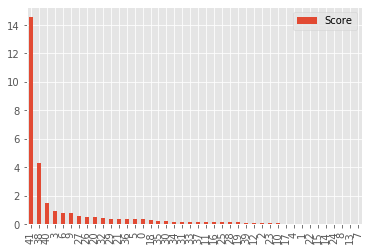

In [71]:
importance = logit_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent

#### SMOTE

In [72]:
#SMOTE
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nSGD Baseline F1 score: ", f1_score(y_test,sgd.predict(X_test)))

SMOTE: 
SGD Baseline F1 score:  0.49875311720698257


In [73]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.68 s, sys: 126 ms, total: 2.8 s
Wall time: 10.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='f1')

In [74]:
print("SMOTE: \n")
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set F1 score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set F1 score: ", f1_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
SMOTE_sgd = businessgain(y_test,sgd_final.predict(X_test))

SMOTE: 

SGD Grid Search best params:  {'alpha': 0.00038965517241379313, 'max_iter': 1000}
SGD Grid Search Training set F1 score:  0.91161239683652
SGD Best Estimator Validation set F1 score:  0.5076142131979696
SGD Best Estimator Validation set business score:  0.8011762147846404


#### imblearn

In [75]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_ros, y_ros)
print("Imblearn Balanced: \nSGD Baseline F1 score: ", f1_score(y_test,sgd.predict(X_test)))

Imblearn Balanced: 
SGD Baseline F1 score:  0.4842615012106538


In [76]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring='f1', n_jobs=-1)
%time grid_search_sgd.fit(X_ros, y_ros)

CPU times: user 2.6 s, sys: 129 ms, total: 2.73 s
Wall time: 11.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='f1')

In [77]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set F1 score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set F1 score: ", f1_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
imblearn_sgd = businessgain(y_test,sgd_final.predict(X_test))

SGD Grid Search best params:  {'alpha': 0.00015517241379310343, 'max_iter': 100}
SGD Grid Search Training set F1 score:  0.8977602789925736
SGD Best Estimator Validation set F1 score:  0.4739336492890995
SGD Best Estimator Validation set business score:  0.7753380161223439


#### Comparing SMOTE with imblearn

In [78]:
print('SMOTE SGD business score: ', SMOTE_sgd, '\nimblearn SGD business score: ', imblearn_sgd)

SMOTE SGD business score:  0.8011762147846404 
imblearn SGD business score:  0.7753380161223439


In [79]:
business_scores.loc[1] = 'SGD', round(SMOTE_sgd, 2)

In [80]:
confusion_matrix(y_test, sgd_final.predict(X_test))

array([[760, 221],
       [  1, 100]])

In [81]:
print(classification_report(sgd_final.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       761
           1       0.99      0.31      0.47       321

    accuracy                           0.79      1082
   macro avg       0.88      0.66      0.67      1082
weighted avg       0.84      0.79      0.75      1082



#### SGD feature Importance

,Feature,Score
41,isFraudConnected,43.519974
38,NetworkDegree,9.214278
6,Outpatient_Count,8.096251
40,Outpatient,6.285919
3,Claim_Count,4.599044
9,DuplicateClaims,4.383564
39,NoPhysicianCount,4.327338
26,ChronicCond_Depression_1,4.317909
29,ChronicCond_Diabetes_2,4.272186
5,Inpatient_Count,3.532414


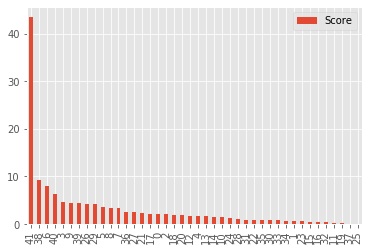

In [82]:
importance = sgd_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### K-Nearest Neighbors

#### SMOTE

In [83]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nKNN Baseline Training Set F1 score: ", f1_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set F1 score: ", f1_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set F1 score:  0.9586392559960841
KNN Baseline Validation Set F1 score:  0.6431095406360424


In [84]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'f1')

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='f1', verbose=1)

In [85]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set F1 score: ", f1_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set F1 score: ", f1_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
SMOTE_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 70}
KNN Grid Search Training set F1 score:  0.8982422575630754
KNN Grid Search Validation set F1 score:  0.5274725274725275
KNN Grid Search Validation set business score:  0.7422697357986512


#### imblearn

In [86]:
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
print("imblearn: \nKNN Baseline Training Set F1 score: ", f1_score(y_ros,knn.predict(X_ros)))
print("KNN Baseline Validation Set F1 score: ", f1_score(y_test,knn.predict(X_test)))

imblearn: 
KNN Baseline Training Set F1 score:  0.9698393077873918
KNN Baseline Validation Set F1 score:  0.6666666666666667


In [87]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'f1')

knn_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='f1', verbose=1)

In [88]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set F1 score: ", f1_score(y_ros, best_knn.predict(X_ros)))
print("KNN Grid Search Validation set F1 score: ", f1_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
imblearn_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 77}
KNN Grid Search Training set F1 score:  0.8811032426388371
KNN Grid Search Validation set F1 score:  0.5519287833827894
KNN Grid Search Validation set business score:  0.7022424442013141


#### Comparing SMOTE and imblearn

In [89]:
print('SMOTE KNN business score: ', SMOTE_knn, '\nimblearn KNN business score: ', imblearn_knn)

SMOTE KNN business score:  0.7422697357986512 
imblearn KNN business score:  0.7022424442013141


In [90]:
business_scores.loc[2] = 'KNN', round(SMOTE_knn, 2)

In [91]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[838, 143],
       [  8,  93]])

In [92]:
print(classification_report(best_knn.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       846
           1       0.92      0.39      0.55       236

    accuracy                           0.86      1082
   macro avg       0.89      0.69      0.73      1082
weighted avg       0.87      0.86      0.84      1082



### Support Vector Machine

#### SMOTE

In [93]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

# baseline score
svm_train_f1 = f1_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_f1 = f1_score(y_test, svm.predict(X_test))

print('SMOTE: \nSVM BaseLine Train Set F1 Score:', svm_train_f1)
print('SVM BaseLine Validation Set F1 Score:', svm_test_f1)

SMOTE: 
SVM BaseLine Train Set F1 Score: 0.9548795944233207
SVM BaseLine Validation Set F1 Score: 0.708171206225681


In [94]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'f1')
svm_GS.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['linear']},
             return_train_score=True, scoring='f1', verbose=1)

In [95]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set F1 score: ", f1_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set F1 score: ", f1_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
SMOTE_svm = businessgain(y_test, best_svm.predict(X_test))

SVM Grid Search Best params:  {'C': 1.0, 'gamma': 'auto', 'kernel': 'linear'}
SVM Grid Search Training set F1 score:  0.9725169372363542
SVM Grid Search Validation set F1 score:  0.8434782608695651
Test Set business Score: 0.8875715380706825


#### imblearn

In [99]:
svm = SVC(class_weight='balanced')
svm.fit(X_ros, y_ros)

# baseline score
svm_train_f1 = f1_score(y_ros, svm.predict(X_ros))
svm_test_f1 = f1_score(y_test, svm.predict(X_test))

print('imblearn: \nSVM BaseLine Train Set F1 Score:', svm_train_f1)
print('SVM BaseLine Validation Set F1 Score:', svm_test_f1)

imblearn: 
SVM BaseLine Train Set F1 Score: 0.935822040398875
SVM BaseLine Validation Set F1 Score: 0.7011070110701106


In [102]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'f1')
svm_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['linear']},
             return_train_score=True, scoring='f1', verbose=1)

In [103]:
print("imblearn: \nSVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set F1 score: ", f1_score(y_ros, best_svm.predict(X_ros)))
print("SVM Grid Search Validation set F1 score: ", f1_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
imblearn_svm = businessgain(y_test, best_svm.predict(X_test))

imblearn: 
SVM Grid Search Best params:  {'C': 100.0, 'gamma': 'auto', 'kernel': 'linear'}
SVM Grid Search Training set F1 score:  0.9678735339112697
SVM Grid Search Validation set F1 score:  0.8571428571428571
Test Set business Score: 0.8714607291101336


#### Comparing SMOTE and imblearn

In [104]:
print('SMOTE SVM business score: ', SMOTE_svm, '\nimblearn SVM business score: ', imblearn_svm)

SMOTE SVM business score:  0.8875715380706825 
imblearn SVM business score:  0.8714607291101336


In [105]:
business_scores.loc[3] = 'SVM', round(SMOTE_svm, 2)

In [106]:
confusion_matrix(y_test, best_svm.predict(X_test))

array([[954,  27],
       [  5,  96]])

In [107]:
print(classification_report(best_svm.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       959
           1       0.95      0.78      0.86       123

    accuracy                           0.97      1082
   macro avg       0.96      0.89      0.92      1082
weighted avg       0.97      0.97      0.97      1082



### Random Forest

#### SMOTE

In [108]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set F1 Score:', f1_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set F1 Score:', f1_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set F1 Score: 1.0
RF BaseLine Validation Set F1 Score: 0.9090909090909091


In [109]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 7.06 s, sys: 411 ms, total: 7.48 s
Wall time: 3min 17s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='f1')

In [110]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set F1 score: ", f1_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set F1 score: ", f1_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 80}
RF Grid Search Training set F1 score:  1.0
RF Grid Search Validation set F1 score:  0.9054726368159204
RF Grid Search Validation set Business score:  0.7844471346418151


#### imblearn

In [111]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set F1 Score:', f1_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set F1 Score:', f1_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set F1 Score: 1.0
RF BaseLine Validation Set F1 Score: 0.9278350515463919


In [112]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 6.73 s, sys: 377 ms, total: 7.11 s
Wall time: 2min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='f1')

In [113]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set F1 score: ", f1_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set F1 score: ", f1_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 21, 'n_estimators': 100}
RF Grid Search Training set F1 score:  1.0
RF Grid Search Validation set F1 score:  0.9183673469387755
RF Grid Search Validation set Business score:  0.7674135328718985


#### comparing SMOTE and imblearn

In [114]:
print('SMOTE RF business score: ', SMOTE_rf, '\nimblearn RF business score: ', imblearn_rf)

SMOTE RF business score:  0.7844471346418151 
imblearn RF business score:  0.7674135328718985


In [115]:
business_scores.loc[4] = 'RF', round(SMOTE_rf, 2)

In [116]:
confusion_matrix(y_test, best_RF.predict(X_test))

array([[976,   5],
       [ 11,  90]])

In [117]:
print(classification_report(best_RF.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       987
           1       0.89      0.95      0.92        95

    accuracy                           0.99      1082
   macro avg       0.94      0.97      0.96      1082
weighted avg       0.99      0.99      0.99      1082



### XGBOOST

#### SMOTE

In [118]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

print('SMOTE: \nXGB BaseLine Train Set F1 Score:', f1_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, xgb.predict(X_test)))

SMOTE: 
XGB BaseLine Train Set F1 Score: 0.9998725302740599
XGB BaseLine Validation Set F1 Score: 0.9207920792079208


In [119]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 } 

grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 1.75 s, sys: 104 ms, total: 1.86 s
Wall time: 11.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...ints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     

In [120]:
print("XGB Grid Search Best params: ", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set F1 Score:', f1_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
SMOTE_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB Grid Search Best params:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 2, 'scale_pos_weight': 400, 'subsample': 0.9}
XGB BaseLine Train Set F1 Score: 0.9171051093183679
XGB BaseLine Validation Set F1 Score: 0.5494505494505495
XGB BaseLine Validation Set business Score: 0.8288599990656723


#### imblearn

In [121]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_ros, y_ros)
print('imblearn: \nXGB BaseLine Train Set F1 Score:', f1_score(y_ros, xgb.predict(X_ros)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, xgb.predict(X_test)))

imblearn: 
XGB BaseLine Train Set F1 Score: 1.0
XGB BaseLine Validation Set F1 Score: 0.91


In [122]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 }
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='f1', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_ros, y_ros)

CPU times: user 2.16 s, sys: 95.2 ms, total: 2.25 s
Wall time: 8.99 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...ints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     

In [123]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set F1 Score:', f1_score(y_ros, best_xgb.predict(X_ros)))
print('XGB BaseLine Validation Set F1 Score:', f1_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
imblearn_xgb = f1_score(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set F1 Score: 0.9021501667241577
XGB BaseLine Validation Set F1 Score: 0.495
XGB BaseLine Validation Set business Score: 0.7739918921116786


#### comparing SMOTE and imblearn

In [124]:
print('SMOTE XGB business score: ', SMOTE_xgb, '\nimblearn XGB business score: ', imblearn_xgb)

SMOTE XGB business score:  0.8288599990656723 
imblearn XGB business score:  0.495


In [125]:
business_scores.loc[5] = 'XGBoost', round(SMOTE_xgb, 2)

In [126]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[781, 200],
       [  2,  99]])

In [127]:
print(classification_report(best_xgb.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       783
           1       0.98      0.33      0.49       299

    accuracy                           0.81      1082
   macro avg       0.89      0.66      0.69      1082
weighted avg       0.85      0.81      0.78      1082



### Business Gain Plot

,Model,Score
0,Logistic,0.88
1,SGD,0.80
2,KNN,0.74
3,SVM,0.89
4,RF,0.78
5,XGBoost,0.83


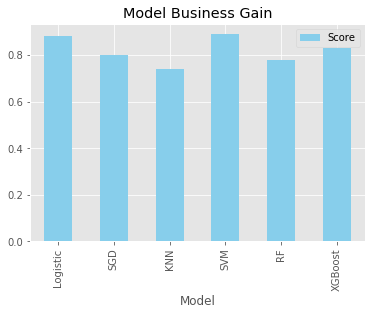

In [128]:
business_scores.plot.bar(x = 'Model', color = 'skyblue')
plt.title('Model Business Gain')
business_scores